In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import *
import torchvision
from torch import nn
from torch.optim import *
from torchvision.transforms import functional, Normalize, RandomRotation
import matplotlib.pyplot as plt
from ipywidgets import *
%matplotlib inline

In [2]:
root_path = '../datasets/cifar10/'
files = os.listdir(root_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
class ImageDataset(Dataset):
    ## transform and target_transform are specific to images.
    def __init__(self,root_path,is_train,mean_vec = None, transform=None, target_transform=None):
        self.root_path = root_path
        self.files = os.listdir(self.root_path)
        self.transform = transform
        self.target_transform = target_transform
        if is_train:
            self.x,self.y = self.read_train_data()
        else:
            self.x,self.y = self.read_test_data()
        
        if is_train:
            self.mean_vec = np.array([np.mean(self.x[:,0,:,:]),
                                      np.mean(self.x[:,1,:,:]),
                                      np.mean(self.x[:,2,:,:])])
        else:
            self.mean_vec = mean_vec
            
        self.std_vec = np.array([1.0,1.0,1.0])
        
        self.x = Normalize(self.mean_vec,self.std_vec)(torch.from_numpy(self.x))
        '''
        if is_train:
            self.x = self.augmentation()
            self.y = np.concatenate((self.y,self.y))
        '''
        
    def read_data_batch(self,file_name):
        with open(file_name,'rb') as f:
            dict_data = pickle.load(f,encoding='latin1')
        return dict_data
    
    def read_train_data(self):
        #x = np.empty((0,3072),dtype=np.float32)
        x = np.empty((0,3072),dtype=np.uint8)
        y = []
        data_size = 0
        for f in self.files[1:-1]:
            train_batch = self.read_data_batch(os.path.join(self.root_path,f))
            #x = np.concatenate((x,train_batch['data']/np.float32(255)))
            x = np.concatenate((x,train_batch['data']))/np.float32(1)
            y.extend(train_batch['labels'])
        data_size = x.shape[0]
        x = x.reshape(data_size,3,32,32)
        return x,np.array(y)
    
    def read_test_data(self):
        data_size = 0
        test_batch = self.read_data_batch(os.path.join(self.root_path,self.files[-1]))
        x = test_batch['data']/np.float32(1)
        y = test_batch['labels']
        data_size = x.shape[0]
        x = x.reshape(data_size,3,32,32)
        return x,np.array(y)
        
    def augmentation(self):
        num_images = self.x.size(0)
        rotater = RandomRotation((0,180))
        rotated_imgs = rotater(self.x)#torch.tensor([rotater(i) for i in self.x])
        return torch.cat((self.x,rotated_imgs))
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self,idx):
        return self.x[idx,:,:,:], self.y[idx]
    
   # .to_tensor


In [4]:
train_dataset = ImageDataset(root_path, is_train = True)
test_dataset = ImageDataset(root_path, mean_vec = train_dataset.mean_vec, is_train = False)
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

In [5]:
class Inception_Module(nn.Module):
    def __init__(self):
        super(Inception_Module, self).__init__()
        self.branch1 = nn.Sequential(
            # OP - 32, 28,28 - C, H, W
            nn.Conv2d(64, 32, kernel_size=(1, 1), stride=1, bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, 
                        track_running_stats=True),
            nn.ReLU(),)
        
        self.branch2 = nn.Sequential(
            # OP - 32, 28,28 - C, H, W
            nn.Conv2d(64, 32, kernel_size=(1, 1), stride=1, bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, 
                        track_running_stats=True),
            nn.ReLU(),
            # OP - 32, 28,28 - C, H, W
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, 
                           track_running_stats=True),
            nn.ReLU(),
        )
        
        self.branch3 = nn.Sequential(
            # OP - 16, 28,28 - C, H, W
            nn.Conv2d(64, 16, kernel_size=(1, 1), stride=1, bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, 
                        track_running_stats=True),
            nn.ReLU(),
            # OP - 16, 28,28 - C, H, W
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=1,padding=1, bias=False),
            nn.BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, 
                        track_running_stats=True),
            nn.ReLU(),
        )
        
        self.branch4 = nn.Sequential(
            # OP - 64, 28, 28
            nn.MaxPool2d((3,3),stride=1, padding=1),
            # OP - 64, 28, 28
            nn.Conv2d(64, 32, kernel_size=(1, 1), padding=0, stride=(1, 1), bias=False),
            # OP - 32, 28, 28 - C, H, W
            nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, 
                           track_running_stats=True),
            nn.ReLU(),
      )
    
    def forward(self, x):
        op1 = self.branch1(x)
        op2 = self.branch2(x)
        op3 = self.branch3(x)
        op4 = self.branch4(x)
        
        # OP - 112, 28,28 - C, H, W
        return torch.cat((op1,op2,op3,op4), dim=1)

    
class Inception_Net(nn.Module):
    def __init__(self):
        super(Inception_Net,self).__init__()
        self.input_conv = nn.Sequential(
            # OP - 64, 30,30 - C, H, W
            nn.Conv2d(3, 64, (5,5), stride=1, padding=1,bias=False),
            nn.BatchNorm2d(64, eps=1e-03, momentum=0.1, affine=True, 
                           track_running_stats=True),
            nn.ReLU(),
            # OP - 64, 28,28 - C, H, W
            nn.MaxPool2d((3,3),stride=1, padding=0),
        )
         
        self.incep = Inception_Module().to(device)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        #self.relu = nn.ReLU(),
        self.dropout = nn.Dropout(p=0.2, inplace=False)
        self.fc = nn.Linear(112,10)
        """"""
        
    def forward(self,x):
        conv1_op = self.input_conv(x)
        incep_op = self.incep(conv1_op)
        ada_pool_op = self.pool(incep_op)
        #relu_after_pool = self.relu(ada_pool_op.squeeze())
        dropout = self.dropout(ada_pool_op.squeeze())
        logits = self.fc(dropout)
        return logits
        """"""
        #return ada_pool_op
    
"""
model = Inception_Net()
model.to(device)
x,y=train_dataset[0:2]
x = x.cuda()
x.to(device)
op=model(x)
"""

'\nmodel = Inception_Net()\nmodel.to(device)\nx,y=train_dataset[0:2]\nx = x.cuda()\nx.to(device)\nop=model(x)\n'

In [6]:
'''
len(op)

print(op[0].shape)
print(op[1].shape)
print(op[2].shape)
print(op[3].shape)

cat_ten = torch.cat((op[0],op[1],op[2],op[3]), dim=1)
cat_ten.shape

#torch.Size([2, 112, 28, 28]) - inception output size
op.squeeze().shape
op.shape


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model
'''


"\nlen(op)\n\nprint(op[0].shape)\nprint(op[1].shape)\nprint(op[2].shape)\nprint(op[3].shape)\n\ncat_ten = torch.cat((op[0],op[1],op[2],op[3]), dim=1)\ncat_ten.shape\n\n#torch.Size([2, 112, 28, 28]) - inception output size\nop.squeeze().shape\nop.shape\n\n\nmodel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)\nmodel\n"

In [7]:

def train(model, optimizer, loss_fn, train_dataloader,train_loss):
    model.train()
    for batch, (x_train,y_train) in enumerate(train_dataloader):
        x_train = x_train.cuda()
        x_train.to(device)
        y_train = y_train.cuda()
        y_train.to(device)
        #x_train = torch.from_numpy(x_train).float().to(device)
        logits = model(x_train)
        # model.to(device)
        loss_val = loss_fn(logits, y_train)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch%100==0:
            print("Batch Loss: ", loss_val.item())
            train_loss.append(loss_val.item())
    return model, train_loss

def test(model, test_dataloader,loss_fn,test_loss,test_acc):
    model.eval()
    total_loss = 0
    total_acc = 0
    num_batches = len(test_dataloader)
    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            logits = model(x_test)
            loss_val = loss_fn(logits, y_test)
            total_loss += loss_val
            total_acc += (logits.argmax(1)==y_test).type(torch.float).sum().item()
    print("Batch Loss Val: ", total_loss.item()/num_batches)
    
    print("Accuracy: ", total_acc)
    test_loss.append(total_loss.item())
    test_acc.append(total_acc)
    return test_loss,test_acc

In [8]:
model = Inception_Net().to(device)
loss_fn = nn.CrossEntropyLoss()
#optimizer = Adam(model.parameters(),lr=0.0008,weight_decay=0.02)
optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.002)
print(device)

cuda


In [11]:
epochs = 30
train_loss = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    print("Epoch: ", epoch)
    model,train_loss = train(model, optimizer, loss_fn, train_dataloader,train_loss)
    test_loss,test_acc = test(model, test_dataloader,loss_fn,test_loss,test_acc)

Epoch:  0
Batch Loss:  1.1634465456008911
Batch Loss:  1.1396952867507935
Batch Loss:  1.1243971586227417
Batch Loss:  0.9264118075370789
Batch Loss Val:  1.1523106249072883
Accuracy:  5865.0
Epoch:  1
Batch Loss:  1.2340432405471802
Batch Loss:  1.0636944770812988
Batch Loss:  1.1285251379013062
Batch Loss:  1.0802862644195557
Batch Loss Val:  1.051652353021163
Accuracy:  6237.0
Epoch:  2
Batch Loss:  0.906238853931427
Batch Loss:  0.9563736915588379
Batch Loss:  1.0353212356567383
Batch Loss:  1.092936635017395
Batch Loss Val:  1.0695201052895076
Accuracy:  6191.0
Epoch:  3
Batch Loss:  1.0689972639083862
Batch Loss:  1.1540718078613281
Batch Loss:  1.0266622304916382
Batch Loss:  1.1339900493621826
Batch Loss Val:  1.039826308624654
Accuracy:  6376.0
Epoch:  4
Batch Loss:  1.0578382015228271
Batch Loss:  1.0493894815444946
Batch Loss:  1.0294685363769531
Batch Loss:  1.1017651557922363
Batch Loss Val:  1.051189760618572
Accuracy:  6410.0
Epoch:  5
Batch Loss:  1.0953024625778198
Bat

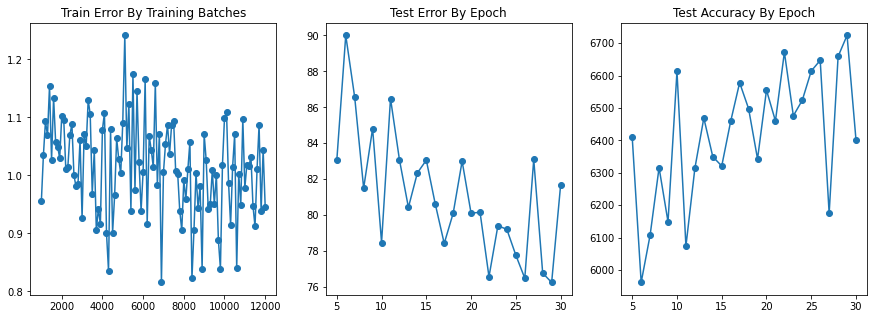

In [12]:
fig, ax = plt.subplots(1,3)
train_batches = [i for i in range(100, 100*(len(train_loss)+1),100)]
test_epochs = [i for i in range(1,len(test_loss)+1)]
ax[0].plot(train_batches[9:], train_loss[9:])
ax[0].scatter(train_batches[9:], train_loss[9:])
ax[0].set_title('Train Error By Training Batches')
ax[1].plot(test_epochs[4:],test_loss[4:])
ax[1].scatter(test_epochs[4:],test_loss[4:])
ax[1].set_title('Test Error By Epoch')
ax[2].plot(test_epochs[4:], test_acc[4:])
ax[2].scatter(test_epochs[4:], test_acc[4:])
ax[2].set_title('Test Accuracy By Epoch')
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()